In [131]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, SimpleRNN, GRU, LSTM, GlobalMaxPooling1D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD, Adam
from scipy.special import softmax
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
tf.__version__

'2.2.0-dev20200414'

# AR model with Keras API

 - It is possible so build AR models with keras API since gradient descent algo will converge OLS solition.
 
 - The aim is to see how we do 1-step ahead and multi-step ahead prediction with Keras API
 
 - Also we will look at the comparison of 1-step ahead and multi-step ahead prediction in cases of smooth and noisy process.

## Generate process - No noise

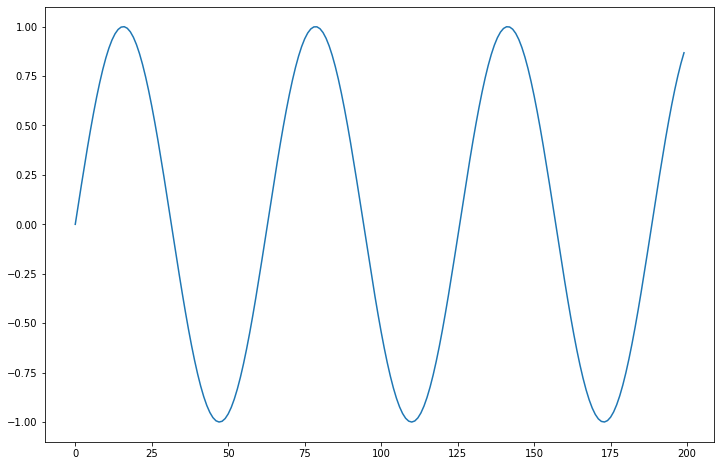

In [4]:
# make the original data, we generate smooth sin waves
series = np.sin(0.1*np.arange(200)) 

# plot it
plt.figure(figsize=(12,8))
plt.plot(series)
plt.show()

## Prepare data for training and testing

In [5]:
# build the dataset
# let's see if we can use T past values to predict the next value
T = 10  # AR(10)
X = []
Y = []
# Since we will have target avaliable at most at len(series) - T
# Loop goes to len(series) - T
for t in range(len(series) - T):
    x = series[t:t+T] 
    X.append(x) # Append prev 10 steps
    y = series[t+T] 
    Y.append(y) # Append 1-step ahead

X = np.array(X).reshape(-1, T)
Y = np.array(Y)
N = len(X)
print("X.shape", X.shape, "Y.shape", Y.shape)

X.shape (190, 10) Y.shape (190,)


## Create AR model wih keras API

In [6]:
# AR(10) model with mini-batch gradient descent
# Analtically it is possible to write sin waves as AR(2)
i = Input(shape=(T,)) # Input layer, features -> Time steps
x = Dense(1)(i) # Dense layer with 1 node without activation function -> AR process
model = Model(i, x) # Build model
model.compile(
  loss='mse',
  optimizer=Adam(lr=0.1), # Keeping lr high since close form exist
) # Compile it with MSE, equivalent to OLS solution

# train the AR
r = model.fit(
  X[:-N//2], Y[:-N//2], # Train-valid split time series version, no shuffle
  epochs=80,
  validation_data=(X[-N//2:], Y[-N//2:]))

Train on 95 samples, validate on 95 samples
Epoch 1/80
95/95 [==============================] - 0s 3ms/sample - loss: 0.4341 - val_loss: 0.3405
Epoch 2/80
95/95 [==============================] - 0s 109us/sample - loss: 0.3034 - val_loss: 0.0379
Epoch 3/80
95/95 [==============================] - 0s 94us/sample - loss: 0.0826 - val_loss: 0.1098
Epoch 4/80
95/95 [==============================] - 0s 98us/sample - loss: 0.1004 - val_loss: 0.0042
Epoch 5/80
95/95 [==============================] - 0s 124us/sample - loss: 0.0205 - val_loss: 0.0661
Epoch 6/80
95/95 [==============================] - 0s 128us/sample - loss: 0.0567 - val_loss: 0.0095
Epoch 7/80
95/95 [==============================] - 0s 118us/sample - loss: 0.0164 - val_loss: 0.0480
Epoch 8/80
95/95 [==============================] - 0s 96us/sample - loss: 0.0366 - val_loss: 0.0204
Epoch 9/80
95/95 [==============================] - 0s 117us/sample - loss: 0.0115 - val_loss: 0.0178
Epoch 10/80
95/95 [========================

Epoch 76/80
95/95 [==============================] - 0s 101us/sample - loss: 1.2231e-11 - val_loss: 8.2851e-12
Epoch 77/80
95/95 [==============================] - 0s 89us/sample - loss: 8.4291e-12 - val_loss: 6.7532e-12
Epoch 78/80
95/95 [==============================] - 0s 95us/sample - loss: 3.6916e-12 - val_loss: 8.3705e-12
Epoch 79/80
95/95 [==============================] - 0s 114us/sample - loss: 4.5597e-12 - val_loss: 7.9873e-13
Epoch 80/80
95/95 [==============================] - 0s 114us/sample - loss: 1.7993e-12 - val_loss: 1.9132e-12


## Loss per epoch

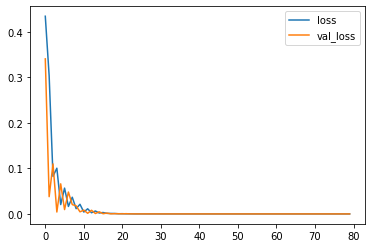

In [7]:
# Plot loss per iteration
import matplotlib.pyplot as plt
plt.plot(r.history['loss'], label='loss')
plt.plot(r.history['val_loss'], label='val_loss')
plt.legend()

## 1-step ahead prediction

In [8]:
validation_target = Y[-N//2:]
validation_predictions = []

# index of first validation input
i = -N//2

while len(validation_predictions) < len(validation_target):
    p = model.predict(X[i].reshape(1, -1))[0,0] # 1x1 array -> scalar
    i += 1 # Update the index and move on
  
  # update the predictions list
    validation_predictions.append(p)

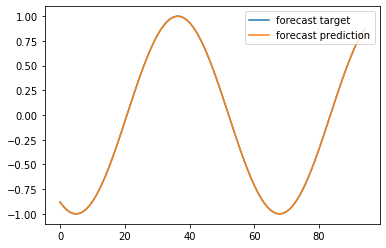

In [9]:
# Perfect fit

plt.plot(validation_target, label='forecast target')
plt.plot(validation_predictions, label='forecast prediction')
plt.legend()

## Multi-step ahead prediction

In [10]:
validation_target = Y[-N//2:]
validation_predictions = []

x_last = X[-N//2] # set initial manually, firs instance in valid data

while len(validation_predictions) < len(validation_target):
    p = model.predict(x_last.reshape(1, -1))[0,0]
    validation_predictions.append(p)
    x_last = np.roll(x_last, -1) # Roll the array to the left, index 0 becomes index -1
    x_last[-1] = p # replace t-2 with t-1 which corresponds to our prediction at t-1

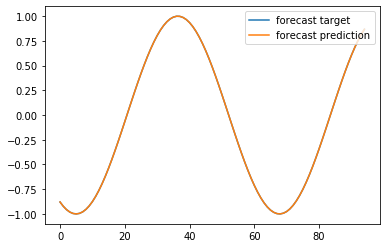

In [11]:
# Perfect fit

plt.plot(validation_target, label='forecast target')
plt.plot(validation_predictions, label='forecast prediction')
plt.legend()

## Generate process - Noisy

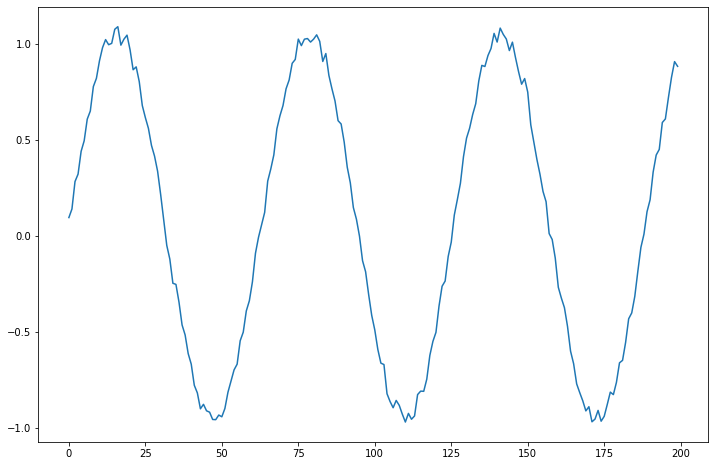

In [35]:
# make the original data, with noise
series = np.sin(0.1*np.arange(200)) + np.random.rand(200)*0.1

# plot it
plt.figure(figsize=(12,8))
plt.plot(series)
plt.show()

## Follow same steps

In [36]:
# build the dataset
# let's see if we can use T past values to predict the next value
T = 10  # AR(10)
X = []
Y = []
# Since we will have target avaliable at most at len(series) - T
# Loop goes to len(series) - T
for t in range(len(series) - T):
    x = series[t:t+T] 
    X.append(x) # Append prev 10 steps
    y = series[t+T] 
    Y.append(y) # Append 1-step ahead

X = np.array(X).reshape(-1, T)
Y = np.array(Y)
N = len(X)
print("X.shape", X.shape, "Y.shape", Y.shape)

X.shape (190, 10) Y.shape (190,)


In [37]:
# AR(10) model with mini-batch gradient descent
# Analtically it is possible to write sin waves as AR(2)
i = Input(shape=(T,)) # Input layer, features -> Time steps
x = Dense(1)(i) # Dense layer with 1 node without activation function -> AR process
model = Model(i, x) # Build model
model.compile(
  loss='mse',
  optimizer=Adam(lr=0.1), # Keeping lr high since close form exist
) # Compile it with MSE, equivalent to OLS solution

# train the AR
r = model.fit(
  X[:-N//2], Y[:-N//2], # Train-valid split time series version, no shuffle
  epochs=80,
  validation_data=(X[-N//2:], Y[-N//2:]))

Train on 95 samples, validate on 95 samples
Epoch 1/80
95/95 [==============================] - 0s 2ms/sample - loss: 1.4989 - val_loss: 0.2850
Epoch 2/80
95/95 [==============================] - 0s 102us/sample - loss: 0.6706 - val_loss: 0.7510
Epoch 3/80
95/95 [==============================] - 0s 89us/sample - loss: 0.7069 - val_loss: 0.1543
Epoch 4/80
95/95 [==============================] - 0s 98us/sample - loss: 0.1230 - val_loss: 0.1882
Epoch 5/80
95/95 [==============================] - 0s 103us/sample - loss: 0.3197 - val_loss: 0.2480
Epoch 6/80
95/95 [==============================] - 0s 100us/sample - loss: 0.2266 - val_loss: 0.0192
Epoch 7/80
95/95 [==============================] - 0s 102us/sample - loss: 0.0285 - val_loss: 0.0829
Epoch 8/80
95/95 [==============================] - 0s 110us/sample - loss: 0.1225 - val_loss: 0.0942
Epoch 9/80
95/95 [==============================] - 0s 107us/sample - loss: 0.0648 - val_loss: 0.0055
Epoch 10/80
95/95 [=======================

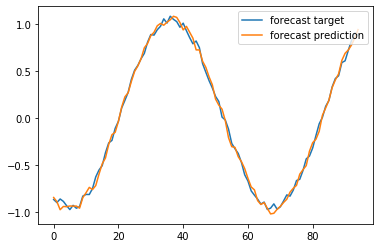

In [38]:
# 1-step ahead
validation_target = Y[-N//2:]
validation_predictions = []

# index of first validation input
i = -N//2

while len(validation_predictions) < len(validation_target):
    p = model.predict(X[i].reshape(1, -1))[0,0] # 1x1 array -> scalar
    i += 1 # Update the index and move on
  
  # update the predictions list
    validation_predictions.append(p)
    
# Perfect fit

plt.plot(validation_target, label='forecast target')
plt.plot(validation_predictions, label='forecast prediction')
plt.legend()

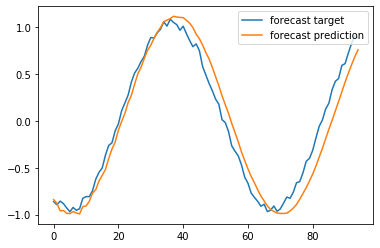

In [39]:
# Multi-step

validation_target = Y[-N//2:]
validation_predictions = []

x_last = X[-N//2] # set initial manually, firs instance in valid data

while len(validation_predictions) < len(validation_target):
    p = model.predict(x_last.reshape(1, -1))[0,0]
    validation_predictions.append(p)
    x_last = np.roll(x_last, -1) # Roll the array to the left, index 0 becomes index -1
    x_last[-1] = p # replace t-2 with t-1 which corresponds to our prediction at t-1


plt.plot(validation_target, label='forecast target')
plt.plot(validation_predictions, label='forecast prediction')
plt.legend()

 - When we have noise in the data 1-step ahead predictions better compared to multi-step
 
 - Model still able to learn underlying path is smooth
 
 - 1 Nice point here is to see it is possible to build any linear model through keras API using Dense layers.

# RNNs

 - RNN operaion is given by:
 
 $$h_t = \sigma(W_{xh}^Tx_t + W_{hh}^T h_{t-1} + b_h)$$
 
 $$\hat{y}_t = \sigma(W_o^T h_t + b_o)$$
 
 - Where:
 
 $$h_t = \text{Hidden state at t }$$
 
 $$W_{xh} = \text{Weight matrix from input to hidden unit }$$
 
 $$W_{hh} = \text{Weight matrix from hidden to hidden unit }$$
 
 $$W_o = \text{Weight matrix from hidden to output}$$
 
 $$b = \text{Corresponding biases}$$
 
 
 - Note that no matter how miny time steps we have we have 1 weight marix for each corresponding connection, meaning as in the case of CNN weights between time steps are shared. And also we have substrict t in $\hat{y}$, meaning RNN doing 1 prediction at each step.
 
 - Where in FFNN case we have:
 
 $$h = \sigma(W_h^Tx + b_h)$$
 
 $$\hat{y} = \sigma(W_o^Th + b_o)$$
 
 
 - Sigma is just arbitarary, activation can be anything.

## RNN Examples

### Pseudocode of RNN

In [97]:
# We avoid bias terms
T = 5 # 5 time-hidden states
y_hat = [] # preds. at each step
h_last = np.zeros(1).reshape(1,1) # setting initial state to 0
x = np.random.randn(20).reshape(5,-1) # Arbitrary. 4 features for each step
w_xh = np.array([1,2,3,4]).reshape(1,4) # input to hidden weights
w_hh = np.array([1]).reshape(1,1) # hidden to hidden weights
w_o = np.array([[1], [2]]) # hidden to out put weights

for t in range(T):
    # Calculate hidden state
    h_t = np.tanh(x[t].reshape(1, 4).dot(np.transpose(w_xh)) + h_last.dot(np.transpose(w_hh)))
    # hidden state prediction - assuming classification
    y_pred = softmax(h_t.dot(np.transpose(w_o)))
    # Store the prediction
    y_hat.append(y_pred)
    # Update the last hidden state
    h_last = h_t

In [110]:
print(" Predictions at each step is given by:")
y_hat

 Predictions at each step is given by:


[array([[0.73092063, 0.26907937]]),
 array([[0.73105552, 0.26894448]]),
 array([[0.26898605, 0.73101395]]),
 array([[0.26894142, 0.73105858]]),
 array([[0.26894255, 0.73105745]])]

### Linear RNN with smooth Sine waves

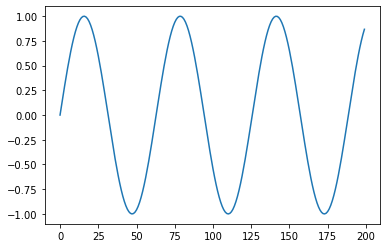

In [111]:
# make the original data
series = np.sin(0.1*np.arange(200))


plt.plot(series)
plt.show()

In [113]:
### build the dataset
# let's see if we can use T past values to predict the next value
T = 10
K = 1
X = []
Y = []
for t in range(len(series) - T):
    x = series[t:t+T]
    X.append(x)
    y = series[t+T]
    Y.append(y)

X = np.array(X).reshape(-1, T, K) # Now the data should be N x T x K
Y = np.array(Y)
N = len(X)
print("X.shape", X.shape, "Y.shape", Y.shape)

X.shape (190, 10, 1) Y.shape (190,)


In [119]:
### try autoregressive RNN model
i = Input(shape=(T, 1))
x = SimpleRNN(1, activation=None)(i)
x = Dense(1)(x)
model = Model(i, x)
model.compile(
  loss='mse',
  optimizer=Adam(lr=0.1),
)

# train the RNN
r = model.fit(
  X[:-N//2], Y[:-N//2],
  epochs=200,
  validation_data=(X[-N//2:], Y[-N//2:]),
)

Train on 95 samples, validate on 95 samples
Epoch 1/200
95/95 [==============================] - 1s 7ms/sample - loss: 0.1910 - val_loss: 0.0242
Epoch 2/200
95/95 [==============================] - 0s 265us/sample - loss: 0.0110 - val_loss: 0.0555
Epoch 3/200
95/95 [==============================] - 0s 262us/sample - loss: 0.0393 - val_loss: 0.0275
Epoch 4/200
95/95 [==============================] - 0s 252us/sample - loss: 0.0133 - val_loss: 0.0038
Epoch 5/200
95/95 [==============================] - 0s 247us/sample - loss: 0.0085 - val_loss: 0.0166
Epoch 6/200
95/95 [==============================] - 0s 271us/sample - loss: 0.0178 - val_loss: 0.0122
Epoch 7/200
95/95 [==============================] - 0s 246us/sample - loss: 0.0075 - val_loss: 0.0025
Epoch 8/200
95/95 [==============================] - 0s 266us/sample - loss: 0.0051 - val_loss: 0.0078
Epoch 9/200
95/95 [==============================] - 0s 251us/sample - loss: 0.0078 - val_loss: 0.0087
Epoch 10/200
95/95 [===========

95/95 [==============================] - 0s 190us/sample - loss: 2.2073e-09 - val_loss: 8.6461e-10
Epoch 155/200
95/95 [==============================] - 0s 200us/sample - loss: 6.9406e-10 - val_loss: 1.0041e-10
Epoch 156/200
95/95 [==============================] - 0s 207us/sample - loss: 3.9486e-10 - val_loss: 6.0028e-10
Epoch 157/200
95/95 [==============================] - 0s 189us/sample - loss: 5.7424e-10 - val_loss: 6.8376e-10
Epoch 158/200
95/95 [==============================] - 0s 194us/sample - loss: 7.7933e-10 - val_loss: 9.9106e-10
Epoch 159/200
95/95 [==============================] - 0s 204us/sample - loss: 8.0976e-10 - val_loss: 4.2749e-10
Epoch 160/200
95/95 [==============================] - 0s 197us/sample - loss: 6.6223e-10 - val_loss: 3.3185e-10
Epoch 161/200
95/95 [==============================] - 0s 198us/sample - loss: 5.8444e-10 - val_loss: 5.5842e-11
Epoch 162/200
95/95 [==============================] - 0s 193us/sample - loss: 3.0900e-10 - val_loss: 2.7532e-

In [120]:
# 1-step ahead

validation_target = Y[-N//2:]
validation_predictions = []

# index of first validation input
i = -N//2

while len(validation_predictions) < len(validation_target):
    p = model.predict(X[i].reshape(1, -1, 1))[0,0] # 1x1 array -> scalar
    i += 1
  
  # update the predictions list
    validation_predictions.append(p)

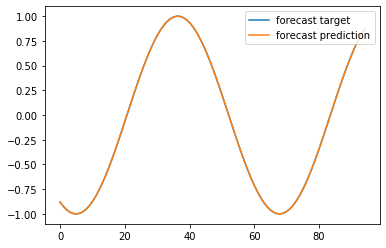

In [121]:
plt.plot(validation_target, label='forecast target')
plt.plot(validation_predictions, label='forecast prediction')
plt.legend()

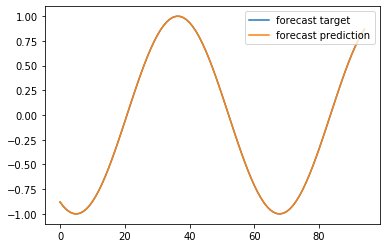

In [122]:
# Forecast future values (use only self-predictions for making future predictions)

validation_target = Y[-N//2:]
validation_predictions = []

# first validation input
last_x = X[-N//2] # 1-D array of length T

while len(validation_predictions) < len(validation_target):
    p = model.predict(last_x.reshape(1, -1, 1))[0,0] # 1x1 array -> scalar
  
  # update the predictions list
    validation_predictions.append(p)
  
  # make the new input
    last_x = np.roll(last_x, -1)
    last_x[-1] = p
    
plt.plot(validation_target, label='forecast target')
plt.plot(validation_predictions, label='forecast prediction')
plt.legend()

 - As in the case of AR(10) model linear RNN model perfectly fits smooth function

### Non-linear RNN with smooth Sine waves

In [123]:
# Default activation of SimpleRNN layer is tanh
i = Input(shape=(T, 1))
x = SimpleRNN(1)(i)
x = Dense(1)(x)
model = Model(i, x)
model.compile(
  loss='mse',
  optimizer=Adam(lr=0.1),
)

# train the RNN
r = model.fit(
  X[:-N//2], Y[:-N//2],
  epochs=200,
  validation_data=(X[-N//2:], Y[-N//2:]),
)

Train on 95 samples, validate on 95 samples
Epoch 1/200
95/95 [==============================] - 1s 9ms/sample - loss: 1.1049 - val_loss: 0.1899
Epoch 2/200
95/95 [==============================] - 0s 251us/sample - loss: 0.1517 - val_loss: 0.0803
Epoch 3/200
95/95 [==============================] - 0s 250us/sample - loss: 0.0598 - val_loss: 0.0393
Epoch 4/200
95/95 [==============================] - 0s 256us/sample - loss: 0.0337 - val_loss: 0.0299
Epoch 5/200
95/95 [==============================] - 0s 254us/sample - loss: 0.0311 - val_loss: 0.0260
Epoch 6/200
95/95 [==============================] - 0s 237us/sample - loss: 0.0267 - val_loss: 0.0278
Epoch 7/200
95/95 [==============================] - 0s 245us/sample - loss: 0.0250 - val_loss: 0.0328
Epoch 8/200
95/95 [==============================] - 0s 237us/sample - loss: 0.0248 - val_loss: 0.0305
Epoch 9/200
95/95 [==============================] - 0s 238us/sample - loss: 0.0219 - val_loss: 0.0241
Epoch 10/200
95/95 [===========

95/95 [==============================] - 0s 204us/sample - loss: 8.6999e-04 - val_loss: 9.8072e-04
Epoch 157/200
95/95 [==============================] - 0s 203us/sample - loss: 7.8694e-04 - val_loss: 0.0011
Epoch 158/200
95/95 [==============================] - 0s 206us/sample - loss: 8.2346e-04 - val_loss: 9.7099e-04
Epoch 159/200
95/95 [==============================] - 0s 200us/sample - loss: 8.1426e-04 - val_loss: 9.7046e-04
Epoch 160/200
95/95 [==============================] - 0s 203us/sample - loss: 7.8829e-04 - val_loss: 0.0010
Epoch 161/200
95/95 [==============================] - 0s 204us/sample - loss: 8.0523e-04 - val_loss: 9.6127e-04
Epoch 162/200
95/95 [==============================] - 0s 203us/sample - loss: 8.1749e-04 - val_loss: 9.6088e-04
Epoch 163/200
95/95 [==============================] - 0s 198us/sample - loss: 8.4670e-04 - val_loss: 0.0010
Epoch 164/200
95/95 [==============================] - 0s 198us/sample - loss: 7.7901e-04 - val_loss: 9.6397e-04
Epoch 165

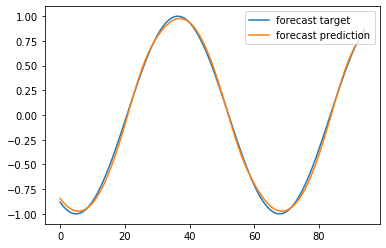

In [124]:
# 1-step ahead

validation_target = Y[-N//2:]
validation_predictions = []

# index of first validation input
i = -N//2

while len(validation_predictions) < len(validation_target):
    p = model.predict(X[i].reshape(1, -1, 1))[0,0] # 1x1 array -> scalar
    i += 1
  
  # update the predictions list
    validation_predictions.append(p)
    
plt.plot(validation_target, label='forecast target')
plt.plot(validation_predictions, label='forecast prediction')
plt.legend()

 - In the non-linear RNN model, even in the 1-step ahead prediction case, predictions are worse compared to a linear RNN model(equivalent to AR model), this is due to true underlying function is linear. Meaning if you shoot a cockroach with a AK-47 there is chance that he will escape but instead if you step on it with a slipper, you decrease the chance he escapes. In contrast to cockroach case, if you are trying to kill a person probably AK-47 will be more effective.
 
 - Meaning if we have a non-linear, complex process it is better to use a non-linear model with a high variance.
 
 - But if the underlying process is a simple linear process, there is a good chance of overfitting.
 
 - Also in this example one can try to use "relu" as activation and see why "tanh" preferred to "relu" in RNNs, it will poorly predict prev. values as current prediction.

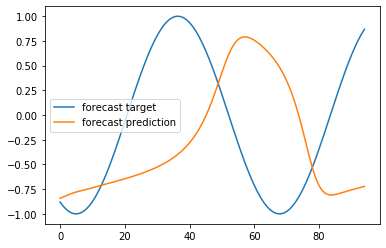

In [125]:
# Forecast future values (use only self-predictions for making future predictions)

validation_target = Y[-N//2:]
validation_predictions = []

# first validation input
last_x = X[-N//2] # 1-D array of length T

while len(validation_predictions) < len(validation_target):
    p = model.predict(last_x.reshape(1, -1, 1))[0,0] # 1x1 array -> scalar
  
  # update the predictions list
    validation_predictions.append(p)
  
  # make the new input
    last_x = np.roll(last_x, -1)
    last_x[-1] = p
    
plt.plot(validation_target, label='forecast target')
plt.plot(validation_predictions, label='forecast prediction')
plt.legend()

 - Where in multi-step ahead forecasts are all over the place
 
 - It is obvious from here what will happen if we use a noisy sine wave, predictions will even get worse since we end up making the task harder.

## LSTM and GRU

 - In simple RNNs and DNNs due to chain rule gradients do not reach to early time-steps, they get smaller and smaller and convege to zero.
 
 - LSTM and GRU aims to solve this problem. LSTM and GRU have the same aim but differs mechanicalally, they both achieve similar performances but sometimes LSTM performs slightly better. GRU compansates this with its efficieny, it is faster compared to LSTM because it requires less matrix operations.
 
 - But in general, wide range of different applications, LSTM tends to perform better.

### GRU

 - GRU cell has 3 units(operations) inside; update gate, reset gate and hidden state, these units are given by:
 
$$Update \ Gate = z_t = \sigma(W_{xz}^T x_t + W_{hz}h_{t-1} + b_z)$$

$$Reset \ Gate = r_t = \sigma(W_{xr}^T x_t + W_{hr}^T h_{t-1} + b_r)$$

$$Hidden \ State \ Gate = h_t = (1 - Z_t) \odot h_{t-1} + z_t \odot tanh\left(W_{xh}^T x_t + W_{hh}^T (r_t \odot h_{t-1})+b_h\right)$$

 - Update gate allows us to carry information from prev. hidden states to current one by allowing us to decide how much of the prev. state should affect current hidden state and how much of the Simple RNN output should affect current hidden state.
 
 - Reset gate allows to asses how much prev. information should affect current simple RNN output should affected by prev hidden states
 
 - Thus we can this these operations as tradeoffs. Update gate decides on the trade-off between hidden states while reset gate decides on the trade-off between curren input and prev. hidden states.
 
 - Sigma here refers to sigmoid activation, and it is not a hyperparameter to play around, those values needs to shrink to 0-1 range.

### LSTM

 - LSTM has 2 hidden state, called hidden state and cell state. Cell state and hidden state can be seen as internal operations optionally we can recover them from the network in general they can be avoided unless the model is custom and we need to different operations with hidden and cell states aditional to operations done internally.
 
  - LSTM units are: forget gate, input/update gate, output gate, cell state and hidden state, these are given by:
  
  $$Forget = f_t = \sigma(W_{xf}^T x_t + W_{hf}^T h_{t-1} + b_f)$$
  
  $$Input/Update = i_t = \sigma(W_{xi}^T x_t + W_{hi}^T h_{t-1} + b_i)$$
  
  $$Output = o_t = \sigma(W_{xo}^T x_t + W_{ho}^T h_{t-1} + b_o)$$
  
  $$Cell \ State = c_t = f_t \odot c_{t-1} + i \odot f_c\left(W_{xc}^T x_t + W_{hc}^T h_{t-1} + b_c \right)$$
  
  $$Hidden \ State = h_t = o_t \odot f_h(c_t)$$
  
  
  - Forget gate controls how much of the prev. cell state should be included in the current cell state. Input/update gate controls how much of the current simple RNN output should be included in current cell state.
  
  - Output gate controls how much of the current cell state should be included in current hidden state.
  
  - Hidden and cell states also refered as short term and long term states. The reason being cell state does similar operations with GRU hidden state with its forget and input gates, meaning it allows information to carried from old states to current one. While hidden state only incorparates information from old time steps through cell state.
  
  - $f_c()$ and $f_h()$ are arbitarary activation functions generally default to "tanh"

### Non-linear process example-LSTM

Process is given by:

$$y_t = Sin((wt)^2)$$

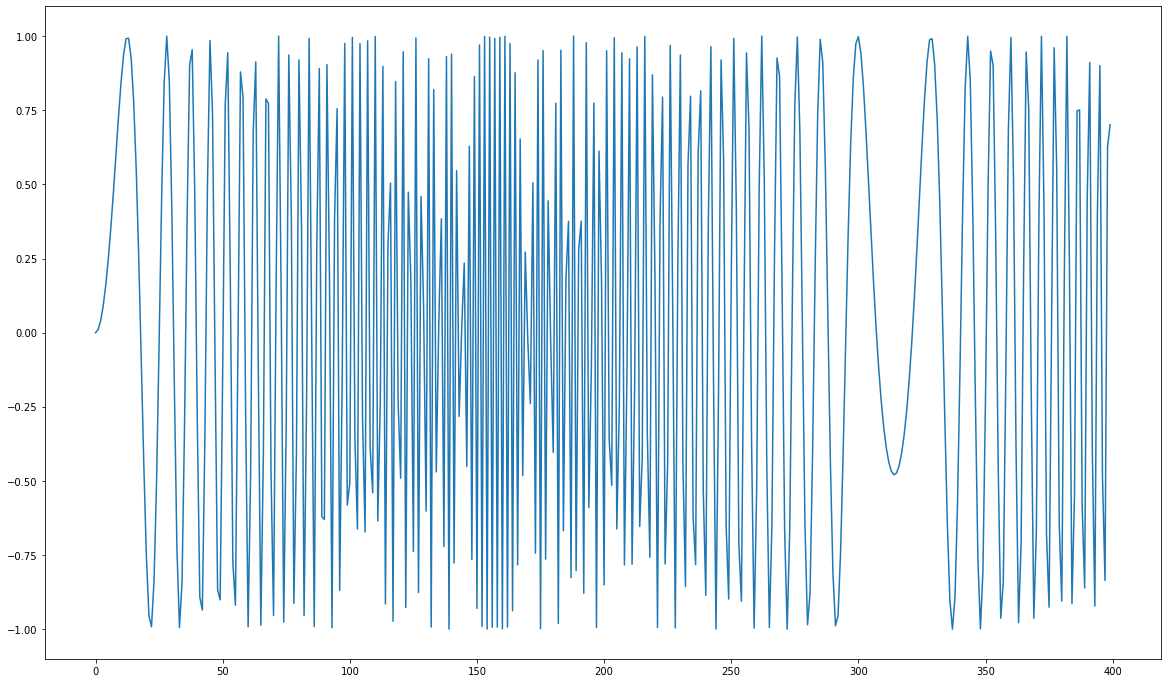

In [127]:
# make the original data
series = np.sin((0.1*np.arange(400))**2)

# plot it
plt.figure(figsize=(20,12))
plt.plot(series)
plt.show()

In [128]:
### build the dataset
# let's see if we can use T past values to predict the next value
T = 10 # 10-time-steps
D = 1 # only using past-values -> single feature for RNN
X = []
Y = []
for t in range(len(series) - T):
    x = series[t:t+T]
    X.append(x)
    y = series[t+T]
    Y.append(y)

X = np.array(X).reshape(-1, T)
Y = np.array(Y)
N = len(X)
print("X.shape", X.shape, "Y.shape", Y.shape)

X.shape (390, 10) Y.shape (390,)


***Linear Model first***

In [129]:
### AR(10)
i = Input(shape=(T,))
x = Dense(1)(i)
model = Model(i, x)
model.compile(
  loss='mse',
  optimizer=Adam(lr=0.01),
)

# train the RNN
r = model.fit(
  X[:-N//2], Y[:-N//2],
  epochs=200,
  validation_data=(X[-N//2:], Y[-N//2:]),
)

Train on 195 samples, validate on 195 samples
Epoch 1/200
195/195 [==============================] - 0s 2ms/sample - loss: 1.4315 - val_loss: 1.3695
Epoch 2/200
195/195 [==============================] - 0s 79us/sample - loss: 1.2108 - val_loss: 1.2143
Epoch 3/200
195/195 [==============================] - 0s 79us/sample - loss: 1.0429 - val_loss: 1.0889
Epoch 4/200
195/195 [==============================] - 0s 75us/sample - loss: 0.9112 - val_loss: 0.9885
Epoch 5/200
195/195 [==============================] - 0s 89us/sample - loss: 0.8092 - val_loss: 0.8960
Epoch 6/200
195/195 [==============================] - 0s 83us/sample - loss: 0.7262 - val_loss: 0.8227
Epoch 7/200
195/195 [==============================] - 0s 77us/sample - loss: 0.6698 - val_loss: 0.7613
Epoch 8/200
195/195 [==============================] - 0s 91us/sample - loss: 0.6247 - val_loss: 0.7050
Epoch 9/200
195/195 [==============================] - 0s 90us/sample - loss: 0.5888 - val_loss: 0.6704
Epoch 10/200
195/19

195/195 [==============================] - 0s 78us/sample - loss: 0.4929 - val_loss: 0.5778
Epoch 156/200
195/195 [==============================] - 0s 77us/sample - loss: 0.4917 - val_loss: 0.5878
Epoch 157/200
195/195 [==============================] - 0s 75us/sample - loss: 0.4900 - val_loss: 0.5966
Epoch 158/200
195/195 [==============================] - 0s 73us/sample - loss: 0.4886 - val_loss: 0.5974
Epoch 159/200
195/195 [==============================] - 0s 75us/sample - loss: 0.4874 - val_loss: 0.5986
Epoch 160/200
195/195 [==============================] - 0s 79us/sample - loss: 0.4888 - val_loss: 0.5970
Epoch 161/200
195/195 [==============================] - 0s 79us/sample - loss: 0.4898 - val_loss: 0.5946
Epoch 162/200
195/195 [==============================] - 0s 79us/sample - loss: 0.4897 - val_loss: 0.5937
Epoch 163/200
195/195 [==============================] - 0s 79us/sample - loss: 0.4883 - val_loss: 0.6035
Epoch 164/200
195/195 [==============================] - 0s 

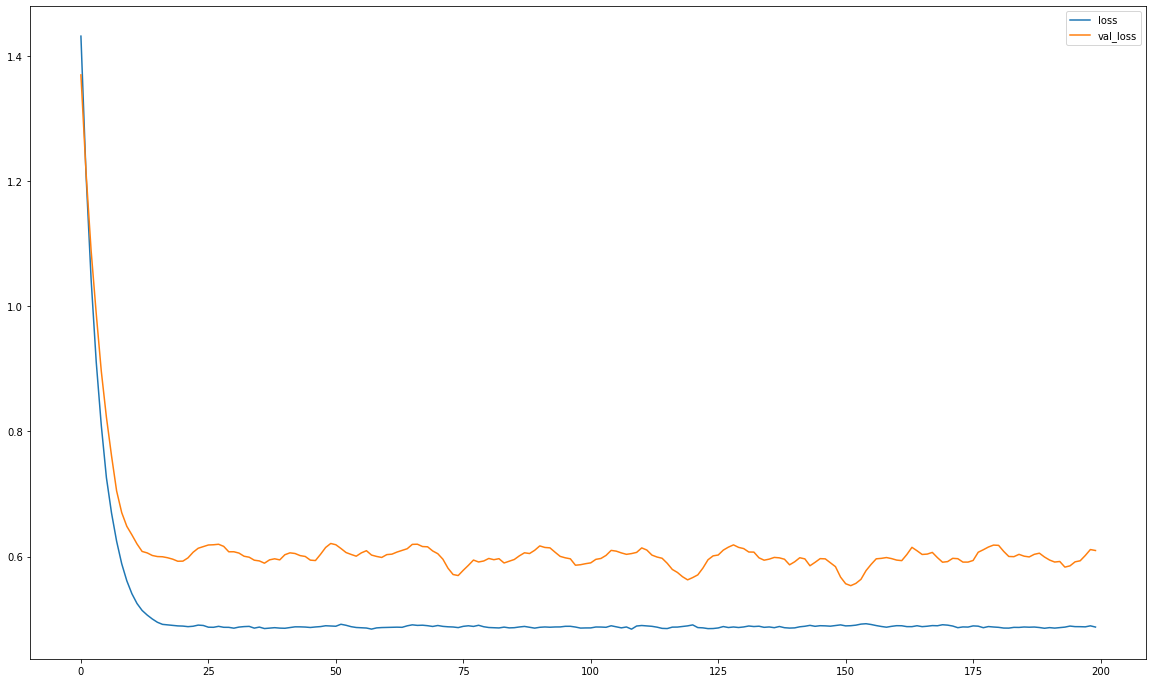

In [130]:
# loss is quite high around 0.6
import matplotlib.pyplot as plt
plt.figure(figsize=(20,12))
plt.plot(r.history['loss'], label='loss')
plt.plot(r.history['val_loss'], label='val_loss')
plt.legend()

(195, 1)


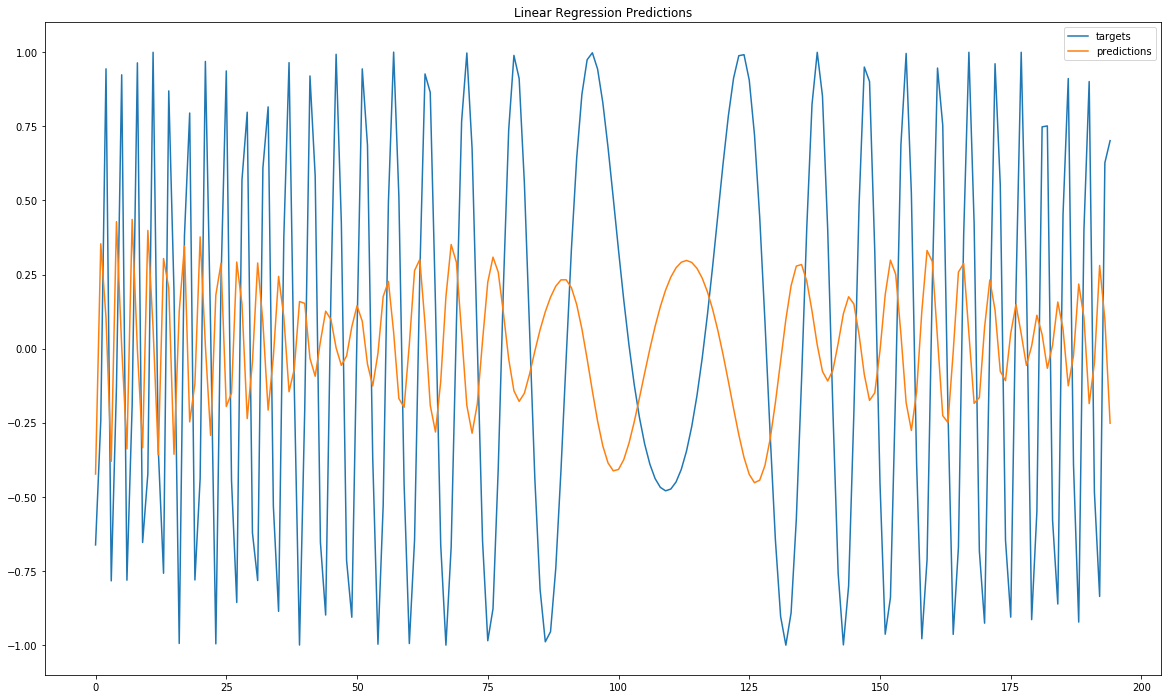

In [133]:
# One-step forecast using true targets
# Note: quite bad, it cannot capture the range of data also makes opposite direction predictions
outputs = model.predict(X[-N//2:])
print(outputs.shape)
predictions = outputs[:,0]

plt.figure(figsize=(20,12))
plt.plot(Y[-N//2:], label='targets')
plt.plot(predictions, label='predictions')
plt.title("Linear Regression Predictions")
plt.legend()
plt.show()

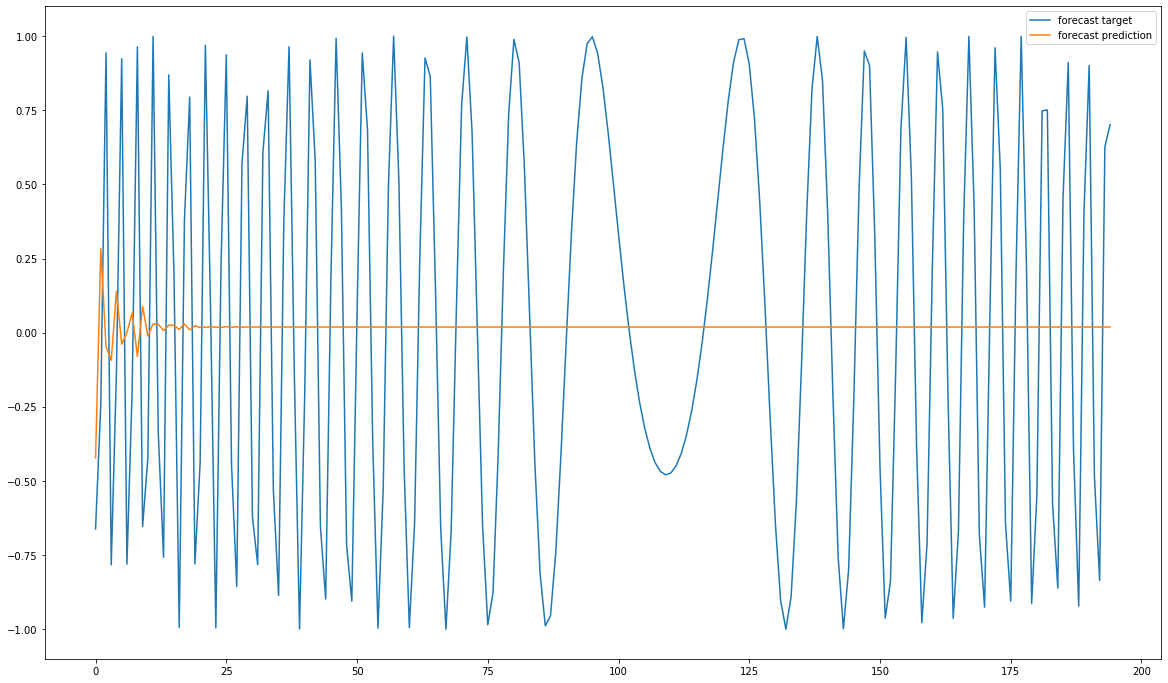

In [134]:
# Multi-step forecast-Fails miserably
validation_target = Y[-N//2:]
validation_predictions = []

# first validation input
last_x = X[-N//2] # 1-D array of length T

while len(validation_predictions) < len(validation_target):
    p = model.predict(last_x.reshape(1, -1))[0,0] # 1x1 array -> scalar
  
  # update the predictions list
    validation_predictions.append(p)
  
  # make the new input
    last_x = np.roll(last_x, -1)
    last_x[-1] = p

plt.figure(figsize=(20,12))
plt.plot(validation_target, label='forecast target')
plt.plot(validation_predictions, label='forecast prediction')
plt.legend()

In [135]:
### Now try RNN/LSTM model
X = X.reshape(-1, T, 1) # make it N x T x D

# make the RNN
i = Input(shape=(T, D))
x = LSTM(10)(i)
x = Dense(1)(x)
model = Model(i, x)
model.compile(
  loss='mse',
  optimizer=Adam(lr=0.05),
)

# train the RNN
r = model.fit(
  X[:-N//2], Y[:-N//2],
  batch_size=32,
  epochs=200,
  validation_data=(X[-N//2:], Y[-N//2:]),
)

Train on 195 samples, validate on 195 samples
Epoch 1/200
195/195 [==============================] - 1s 7ms/sample - loss: 0.5689 - val_loss: 0.5166
Epoch 2/200
195/195 [==============================] - 0s 382us/sample - loss: 0.4976 - val_loss: 0.5286
Epoch 3/200
195/195 [==============================] - 0s 372us/sample - loss: 0.4587 - val_loss: 0.5487
Epoch 4/200
195/195 [==============================] - 0s 360us/sample - loss: 0.3954 - val_loss: 0.5071
Epoch 5/200
195/195 [==============================] - 0s 311us/sample - loss: 0.3291 - val_loss: 0.5037
Epoch 6/200
195/195 [==============================] - 0s 290us/sample - loss: 0.2462 - val_loss: 0.3767
Epoch 7/200
195/195 [==============================] - 0s 301us/sample - loss: 0.1783 - val_loss: 0.2823
Epoch 8/200
195/195 [==============================] - 0s 285us/sample - loss: 0.1351 - val_loss: 0.2773
Epoch 9/200
195/195 [==============================] - 0s 300us/sample - loss: 0.1021 - val_loss: 0.2459
Epoch 10/20

Epoch 78/200
195/195 [==============================] - 0s 275us/sample - loss: 0.0032 - val_loss: 0.0682
Epoch 79/200
195/195 [==============================] - 0s 288us/sample - loss: 0.0029 - val_loss: 0.0494
Epoch 80/200
195/195 [==============================] - 0s 279us/sample - loss: 0.0025 - val_loss: 0.0746
Epoch 81/200
195/195 [==============================] - 0s 276us/sample - loss: 0.0025 - val_loss: 0.0574
Epoch 82/200
195/195 [==============================] - 0s 281us/sample - loss: 0.0026 - val_loss: 0.0685
Epoch 83/200
195/195 [==============================] - 0s 292us/sample - loss: 0.0021 - val_loss: 0.0532
Epoch 84/200
195/195 [==============================] - 0s 310us/sample - loss: 0.0021 - val_loss: 0.0625
Epoch 85/200
195/195 [==============================] - 0s 290us/sample - loss: 0.0019 - val_loss: 0.0505
Epoch 86/200
195/195 [==============================] - 0s 297us/sample - loss: 0.0025 - val_loss: 0.0625
Epoch 87/200
195/195 [========================

Epoch 155/200
195/195 [==============================] - 0s 297us/sample - loss: 0.0017 - val_loss: 0.0383
Epoch 156/200
195/195 [==============================] - 0s 294us/sample - loss: 0.0014 - val_loss: 0.0425
Epoch 157/200
195/195 [==============================] - 0s 293us/sample - loss: 0.0012 - val_loss: 0.0390
Epoch 158/200
195/195 [==============================] - 0s 281us/sample - loss: 0.0029 - val_loss: 0.0467
Epoch 159/200
195/195 [==============================] - 0s 287us/sample - loss: 0.0021 - val_loss: 0.0379
Epoch 160/200
195/195 [==============================] - 0s 279us/sample - loss: 0.0022 - val_loss: 0.0479
Epoch 161/200
195/195 [==============================] - 0s 300us/sample - loss: 0.0020 - val_loss: 0.0382
Epoch 162/200
195/195 [==============================] - 0s 284us/sample - loss: 0.0014 - val_loss: 0.0388
Epoch 163/200
195/195 [==============================] - 0s 293us/sample - loss: 0.0017 - val_loss: 0.0444
Epoch 164/200
195/195 [==============

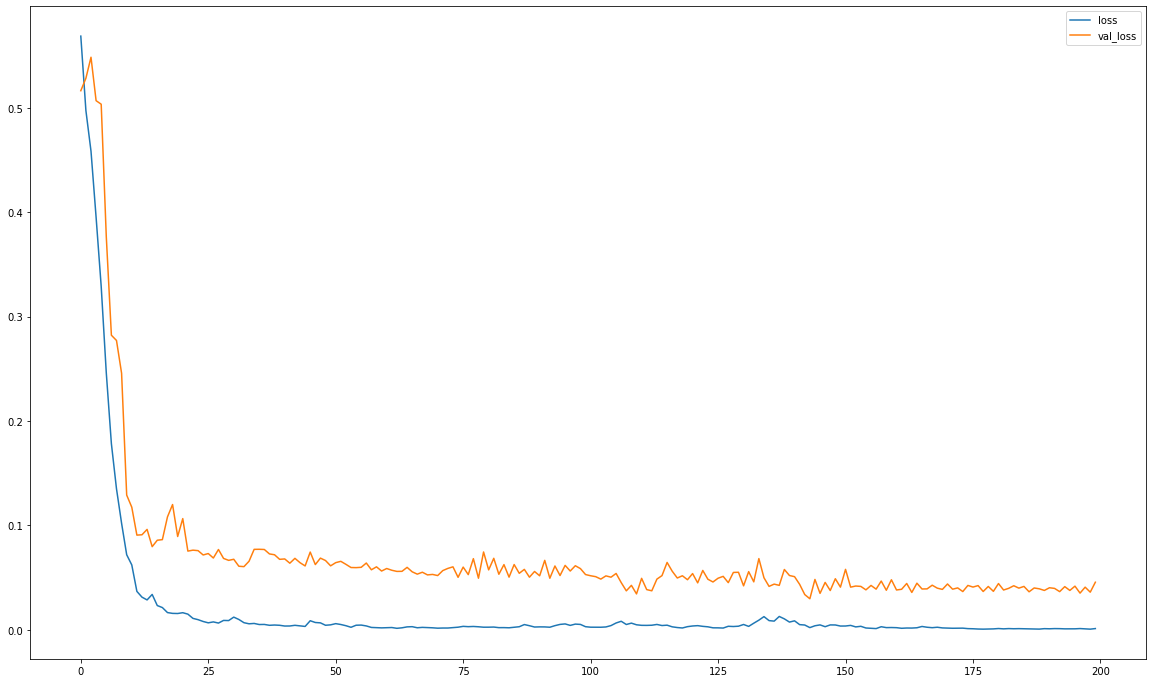

In [136]:
# plot loss - Valid loss much better compared to AR model
plt.figure(figsize=(20,12))
plt.plot(r.history['loss'], label='loss')
plt.plot(r.history['val_loss'], label='val_loss')
plt.legend()
plt.show()

(195, 1)


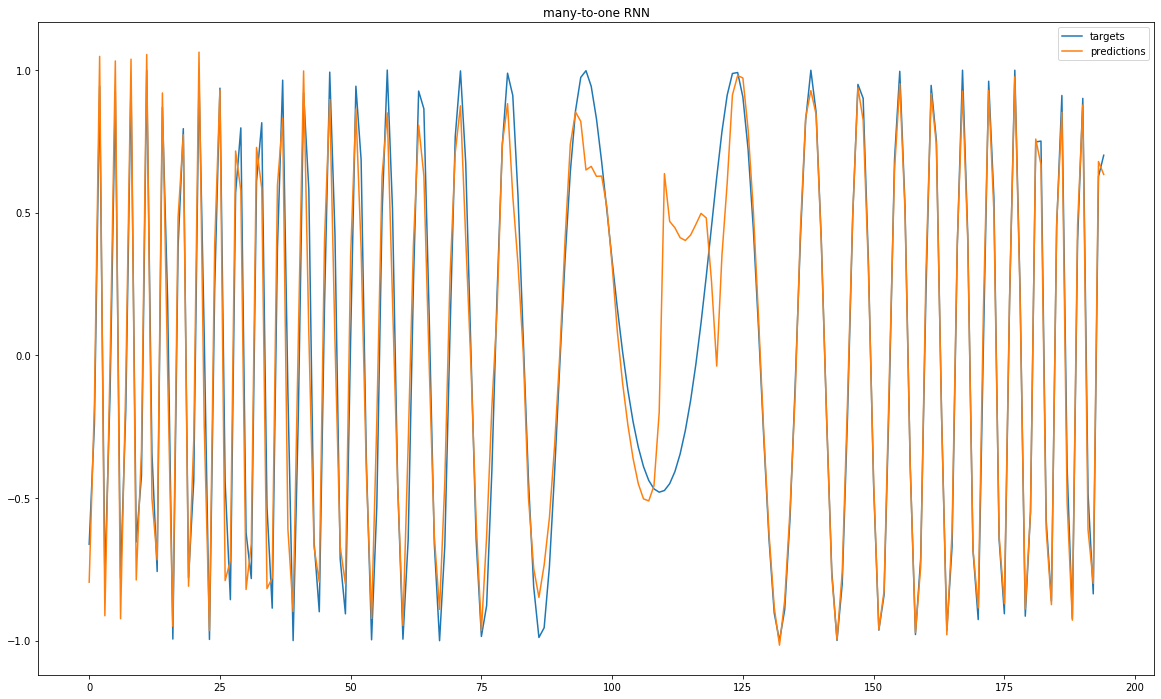

In [137]:
# One-step forecast using true targets
# Much-better compared to AR model
# fails to predict change of behaviour in the process, it is normal considering
# Process does not depend on the past but only can approximated
outputs = model.predict(X[-N//2:])
print(outputs.shape)
predictions = outputs[:,0]

plt.figure(figsize=(20,12))
plt.plot(Y[-N//2:], label='targets')
plt.plot(predictions, label='predictions')
plt.title("many-to-one RNN")
plt.legend()
plt.show()

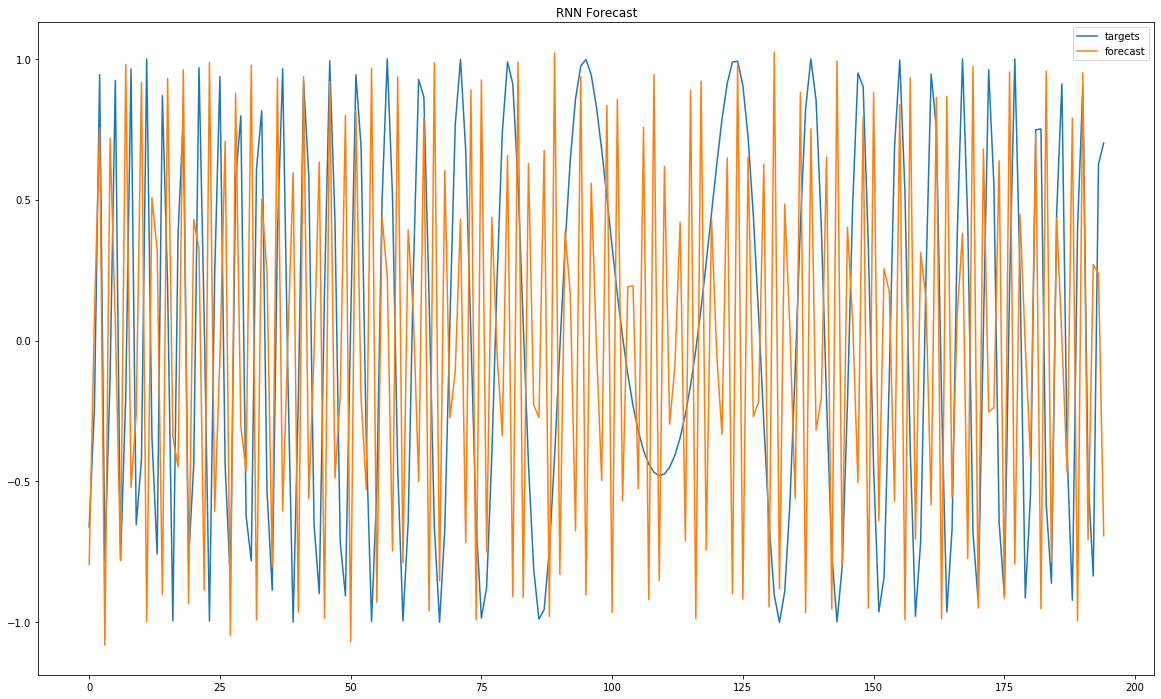

In [138]:
# Multi-step forecast - Not that good
forecast = []
input_ = X[-N//2]
while len(forecast) < len(Y[-N//2:]):
    
  # Reshape the input_ to N x T x D
    f = model.predict(input_.reshape(1, T, 1))[0,0]
    forecast.append(f)

  # make a new input with the latest forecast
    input_ = np.roll(input_, -1)
    input_[-1] = f

plt.figure(figsize=(20,12))
plt.plot(Y[-N//2:], label='targets')
plt.plot(forecast, label='forecast')
plt.title("RNN Forecast")
plt.legend()
plt.show()

 - One point to note this series does not have long term dependency, thus simple RNN would perform similarly to LSTM.

### LSTM vs Simple RNN with long-term dependence

 - This is a nonlinear AND long-short-distance dataset
 - Labels depend on the 3-consective values of Xs
 - we first make it dependent on last 3 consective values which makes the problem, short distance.
 - Then we make it dependent on inital 3 consective values which makes is long-distance, since model needs to remember initial 3 values of the sequence
 -  We increase the diffulty by inreasing number of time-steps.

In [106]:
### build the dataset
# This is a nonlinear AND long-distance dataset
# (Actually, we will test long-distance vs. short-distance patterns)

# Start with a small T and increase it later
T = 10
D = 1
X = []
Y = []

def get_label(x, i1, i2, i3):
  # x = sequence
  if x[i1] < 0 and x[i2] < 0 and x[i3] < 0:
    return 1
  if x[i1] < 0 and x[i2] > 0 and x[i3] > 0:
    return 1
  if x[i1] > 0 and x[i2] < 0 and x[i3] > 0:
    return 1
  if x[i1] > 0 and x[i2] > 0 and x[i3] < 0:
    return 1
  return 0

for t in range(5000):
    x = np.random.randn(T)
    X.append(x)
    y = get_label(x, -1, -2, -3) # short distance
#   y = get_label(x, 0, 1, 2) # long distance
    Y.append(y)

X = np.array(X)
Y = np.array(Y)
N = len(X)

In [107]:
# Try a linear model first
i = Input(shape=(T,))
x = Dense(1, activation='sigmoid')(i)
model = Model(i, x)
model.compile(
  loss='binary_crossentropy',
  optimizer=Adam(lr=0.01),
  metrics=['accuracy'],
)

# train the network
r = model.fit(
  X, Y,
  epochs=100,
  validation_split=0.5,
)

Epoch 1/100
79/79 [==============================] - 0s 3ms/step - loss: 0.7882 - accuracy: 0.4704 - val_loss: 0.7072 - val_accuracy: 0.4888
Epoch 2/100
79/79 [==============================] - 0s 2ms/step - loss: 0.6981 - accuracy: 0.5044 - val_loss: 0.6965 - val_accuracy: 0.4980
Epoch 3/100
79/79 [==============================] - 0s 2ms/step - loss: 0.6933 - accuracy: 0.5264 - val_loss: 0.6977 - val_accuracy: 0.4916
Epoch 4/100
79/79 [==============================] - 0s 2ms/step - loss: 0.6929 - accuracy: 0.5372 - val_loss: 0.6973 - val_accuracy: 0.4948
Epoch 5/100
79/79 [==============================] - 0s 2ms/step - loss: 0.6918 - accuracy: 0.5356 - val_loss: 0.6975 - val_accuracy: 0.4988
Epoch 6/100
79/79 [==============================] - 0s 2ms/step - loss: 0.6925 - accuracy: 0.5276 - val_loss: 0.6983 - val_accuracy: 0.4968
Epoch 7/100
79/79 [==============================] - 0s 2ms/step - loss: 0.6924 - accuracy: 0.5224 - val_loss: 0.6978 - val_accuracy: 0.4996
Epoch 8/100
7

Epoch 59/100
79/79 [==============================] - 0s 2ms/step - loss: 0.6933 - accuracy: 0.5376 - val_loss: 0.6985 - val_accuracy: 0.4936
Epoch 60/100
79/79 [==============================] - 0s 2ms/step - loss: 0.6928 - accuracy: 0.5264 - val_loss: 0.6969 - val_accuracy: 0.5008
Epoch 61/100
79/79 [==============================] - 0s 2ms/step - loss: 0.6930 - accuracy: 0.5300 - val_loss: 0.6971 - val_accuracy: 0.4872
Epoch 62/100
79/79 [==============================] - 0s 2ms/step - loss: 0.6933 - accuracy: 0.5244 - val_loss: 0.6994 - val_accuracy: 0.4872
Epoch 63/100
79/79 [==============================] - 0s 2ms/step - loss: 0.6925 - accuracy: 0.5272 - val_loss: 0.6979 - val_accuracy: 0.4924
Epoch 64/100
79/79 [==============================] - 0s 2ms/step - loss: 0.6917 - accuracy: 0.5264 - val_loss: 0.6963 - val_accuracy: 0.4924
Epoch 65/100
79/79 [==============================] - 0s 2ms/step - loss: 0.6923 - accuracy: 0.5296 - val_loss: 0.6970 - val_accuracy: 0.4932
Epoch 

 - Linear model performs poorly

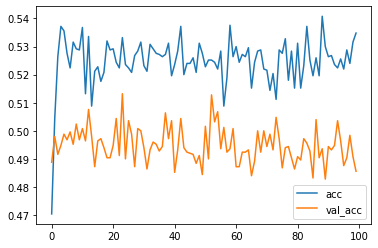

In [108]:
# Plot the accuracy
plt.plot(r.history['accuracy'], label='acc')
plt.plot(r.history['val_accuracy'], label='val_acc')
plt.legend()

In [109]:
# Now try a simple RNN
inputs = np.expand_dims(X, -1)

# make the RNN
i = Input(shape=(T, D))

# method 1
# x = LSTM(5)(i)
x = SimpleRNN(5)(i)
# x = GRU(5)(i)

# method 2
# x = LSTM(5, return_sequences=True)(i)
# x = GlobalMaxPool1D()(x)

x = Dense(1, activation='sigmoid')(x)
model = Model(i, x)
model.compile(
  loss='binary_crossentropy',
  # optimizer='rmsprop',
#   optimizer='adam',
  optimizer=Adam(lr=0.01),
  # optimizer=SGD(lr=0.1, momentum=0.9),
  metrics=['accuracy'],
)

# train the RNN
r = model.fit(
  inputs, Y,
  epochs=200,
  validation_split=0.5,
)

Epoch 1/200
79/79 [==============================] - 0s 6ms/step - loss: 0.6775 - accuracy: 0.6040 - val_loss: 0.6496 - val_accuracy: 0.6452
Epoch 2/200
79/79 [==============================] - 0s 5ms/step - loss: 0.6153 - accuracy: 0.7040 - val_loss: 0.5782 - val_accuracy: 0.7672
Epoch 3/200
79/79 [==============================] - 0s 4ms/step - loss: 0.5377 - accuracy: 0.7860 - val_loss: 0.4972 - val_accuracy: 0.7952
Epoch 4/200
79/79 [==============================] - 0s 4ms/step - loss: 0.4409 - accuracy: 0.8420 - val_loss: 0.3893 - val_accuracy: 0.8676
Epoch 5/200
79/79 [==============================] - 0s 4ms/step - loss: 0.3502 - accuracy: 0.8892 - val_loss: 0.3206 - val_accuracy: 0.8944
Epoch 6/200
79/79 [==============================] - 0s 5ms/step - loss: 0.2936 - accuracy: 0.9052 - val_loss: 0.2691 - val_accuracy: 0.9192
Epoch 7/200
79/79 [==============================] - 0s 5ms/step - loss: 0.2543 - accuracy: 0.9252 - val_loss: 0.2317 - val_accuracy: 0.9316
Epoch 8/200
7

Epoch 59/200
79/79 [==============================] - 0s 4ms/step - loss: 0.0562 - accuracy: 0.9836 - val_loss: 0.0598 - val_accuracy: 0.9828
Epoch 60/200
79/79 [==============================] - 0s 4ms/step - loss: 0.0553 - accuracy: 0.9836 - val_loss: 0.0571 - val_accuracy: 0.9848
Epoch 61/200
79/79 [==============================] - 0s 4ms/step - loss: 0.0524 - accuracy: 0.9844 - val_loss: 0.0594 - val_accuracy: 0.9812
Epoch 62/200
79/79 [==============================] - 0s 4ms/step - loss: 0.0523 - accuracy: 0.9860 - val_loss: 0.0569 - val_accuracy: 0.9816
Epoch 63/200
79/79 [==============================] - 0s 4ms/step - loss: 0.0506 - accuracy: 0.9880 - val_loss: 0.0649 - val_accuracy: 0.9756
Epoch 64/200
79/79 [==============================] - 0s 4ms/step - loss: 0.0611 - accuracy: 0.9812 - val_loss: 0.0561 - val_accuracy: 0.9808
Epoch 65/200
79/79 [==============================] - 0s 4ms/step - loss: 0.0545 - accuracy: 0.9848 - val_loss: 0.0620 - val_accuracy: 0.9748
Epoch 

79/79 [==============================] - 0s 4ms/step - loss: 0.0293 - accuracy: 0.9904 - val_loss: 0.0347 - val_accuracy: 0.9896
Epoch 174/200
79/79 [==============================] - 0s 4ms/step - loss: 0.0349 - accuracy: 0.9896 - val_loss: 0.0368 - val_accuracy: 0.9876
Epoch 175/200
79/79 [==============================] - 0s 4ms/step - loss: 0.0394 - accuracy: 0.9860 - val_loss: 0.0495 - val_accuracy: 0.9796
Epoch 176/200
79/79 [==============================] - 0s 4ms/step - loss: 0.0353 - accuracy: 0.9880 - val_loss: 0.0478 - val_accuracy: 0.9808
Epoch 177/200
79/79 [==============================] - 0s 4ms/step - loss: 0.0314 - accuracy: 0.9892 - val_loss: 0.0375 - val_accuracy: 0.9872
Epoch 178/200
79/79 [==============================] - 0s 4ms/step - loss: 0.0279 - accuracy: 0.9924 - val_loss: 0.0451 - val_accuracy: 0.9840
Epoch 179/200
79/79 [==============================] - 0s 4ms/step - loss: 0.0602 - accuracy: 0.9872 - val_loss: 0.0748 - val_accuracy: 0.9800
Epoch 180/200

 - RNN able to solve non-linear problem with short-distance

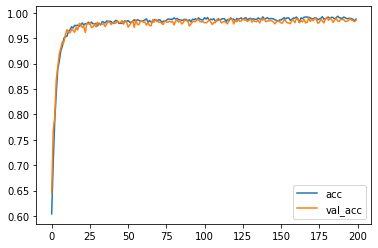

In [110]:
# accuracy
plt.plot(r.history['accuracy'], label='acc')
plt.plot(r.history['val_accuracy'], label='val_acc')
plt.legend()

 - Long-distance problem

In [112]:
# Make the problem harder by making T larger
T = 20
D = 1
X = []
Y = []

for t in range(5000):
    x = np.random.randn(T)
    X.append(x)
    y = get_label(x, 0, 1, 2) # long distance
    Y.append(y)

X = np.array(X)
Y = np.array(Y)
N = len(X)

 - Now we increase the number of nodes, since problem is harder now. If we do not increase the complexity of the model, there will be a lot of difference between different trials.

In [120]:
# set the seed to make models comparable
tf.random.set_seed(123) 

# Now test our Simple RNN again
inputs = np.expand_dims(X, -1)

# make the RNN
i = Input(shape=(T, D))

# method 1
x = SimpleRNN(50)(i)

x = Dense(1, activation='sigmoid')(x)
model = Model(i, x)
model.compile(
  loss='binary_crossentropy',
  optimizer=Adam(lr=0.01),
  metrics=['accuracy'],
)

# train the RNN
r = model.fit(
  inputs, Y,
  epochs=200,
  validation_split=0.5,
)

Epoch 1/200
79/79 [==============================] - 1s 9ms/step - loss: 0.7166 - accuracy: 0.5108 - val_loss: 0.7261 - val_accuracy: 0.4908
Epoch 2/200
79/79 [==============================] - 1s 7ms/step - loss: 0.7086 - accuracy: 0.5040 - val_loss: 0.6929 - val_accuracy: 0.5192
Epoch 3/200
79/79 [==============================] - 1s 7ms/step - loss: 0.6956 - accuracy: 0.5028 - val_loss: 0.7029 - val_accuracy: 0.5092
Epoch 4/200
79/79 [==============================] - 1s 6ms/step - loss: 0.7036 - accuracy: 0.4940 - val_loss: 0.7099 - val_accuracy: 0.4908
Epoch 5/200
79/79 [==============================] - 1s 6ms/step - loss: 0.7018 - accuracy: 0.4916 - val_loss: 0.7205 - val_accuracy: 0.4908
Epoch 6/200
79/79 [==============================] - 0s 6ms/step - loss: 0.7042 - accuracy: 0.5080 - val_loss: 0.7481 - val_accuracy: 0.4896
Epoch 7/200
79/79 [==============================] - 1s 6ms/step - loss: 0.7115 - accuracy: 0.4828 - val_loss: 0.6930 - val_accuracy: 0.5088
Epoch 8/200
7

Epoch 59/200
79/79 [==============================] - 1s 7ms/step - loss: 0.7083 - accuracy: 0.5060 - val_loss: 0.6993 - val_accuracy: 0.5092
Epoch 60/200
79/79 [==============================] - 1s 7ms/step - loss: 0.7024 - accuracy: 0.4984 - val_loss: 0.6946 - val_accuracy: 0.5092
Epoch 61/200
79/79 [==============================] - 1s 7ms/step - loss: 0.7033 - accuracy: 0.4900 - val_loss: 0.6980 - val_accuracy: 0.4908
Epoch 62/200
79/79 [==============================] - 1s 7ms/step - loss: 0.7051 - accuracy: 0.4928 - val_loss: 0.7432 - val_accuracy: 0.4908
Epoch 63/200
79/79 [==============================] - 1s 7ms/step - loss: 0.7029 - accuracy: 0.4832 - val_loss: 0.6937 - val_accuracy: 0.5092
Epoch 64/200
79/79 [==============================] - 1s 7ms/step - loss: 0.6995 - accuracy: 0.4900 - val_loss: 0.7047 - val_accuracy: 0.5092
Epoch 65/200
79/79 [==============================] - 1s 7ms/step - loss: 0.7039 - accuracy: 0.4956 - val_loss: 0.6931 - val_accuracy: 0.5092
Epoch 

79/79 [==============================] - 1s 7ms/step - loss: 0.7016 - accuracy: 0.5012 - val_loss: 0.6966 - val_accuracy: 0.5092
Epoch 174/200
79/79 [==============================] - 1s 7ms/step - loss: 0.6987 - accuracy: 0.5012 - val_loss: 0.6997 - val_accuracy: 0.4908
Epoch 175/200
79/79 [==============================] - 1s 7ms/step - loss: 0.6964 - accuracy: 0.4924 - val_loss: 0.6967 - val_accuracy: 0.5092
Epoch 176/200
79/79 [==============================] - 1s 7ms/step - loss: 0.7079 - accuracy: 0.4868 - val_loss: 0.6947 - val_accuracy: 0.4908
Epoch 177/200
79/79 [==============================] - 1s 7ms/step - loss: 0.7027 - accuracy: 0.4948 - val_loss: 0.6953 - val_accuracy: 0.4908
Epoch 178/200
79/79 [==============================] - 1s 7ms/step - loss: 0.7034 - accuracy: 0.5076 - val_loss: 0.6946 - val_accuracy: 0.5092
Epoch 179/200
79/79 [==============================] - 1s 7ms/step - loss: 0.7048 - accuracy: 0.5100 - val_loss: 0.7857 - val_accuracy: 0.4908
Epoch 180/200

 - Simple RNN fails to learn long-term dependency

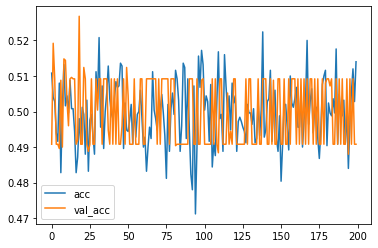

In [121]:
# Plot the accuracy
plt.plot(r.history['accuracy'], label='acc')
plt.plot(r.history['val_accuracy'], label='val_acc')
plt.legend()

 - Test it with LSTM

In [117]:
# Now test our LSTM
inputs = np.expand_dims(X, -1)
tf.random.set_seed(123)
# make the RNN
i = Input(shape=(T, D))

# method 1
x = LSTM(50)(i)

x = Dense(1, activation='sigmoid')(x)
model = Model(i, x)
model.compile(
  loss='binary_crossentropy',
  optimizer=Adam(lr=0.01),
  metrics=['accuracy'],
)

In [118]:
# train the RNN
r = model.fit(
  inputs, Y,
  epochs=200,
  validation_split=0.5,
)

Epoch 1/200
79/79 [==============================] - 1s 16ms/step - loss: 0.6954 - accuracy: 0.5052 - val_loss: 0.6940 - val_accuracy: 0.4904
Epoch 2/200
79/79 [==============================] - 1s 12ms/step - loss: 0.6935 - accuracy: 0.5092 - val_loss: 0.6934 - val_accuracy: 0.4936
Epoch 3/200
79/79 [==============================] - 1s 11ms/step - loss: 0.6937 - accuracy: 0.5088 - val_loss: 0.6933 - val_accuracy: 0.4988
Epoch 4/200
79/79 [==============================] - 1s 11ms/step - loss: 0.6935 - accuracy: 0.5060 - val_loss: 0.6937 - val_accuracy: 0.4940
Epoch 5/200
79/79 [==============================] - 1s 11ms/step - loss: 0.6935 - accuracy: 0.5000 - val_loss: 0.6934 - val_accuracy: 0.4908
Epoch 6/200
79/79 [==============================] - 1s 11ms/step - loss: 0.6934 - accuracy: 0.5096 - val_loss: 0.6931 - val_accuracy: 0.5020
Epoch 7/200
79/79 [==============================] - 1s 12ms/step - loss: 0.6935 - accuracy: 0.5156 - val_loss: 0.6931 - val_accuracy: 0.5104
Epoch 

79/79 [==============================] - 1s 12ms/step - loss: 0.0161 - accuracy: 0.9944 - val_loss: 0.0659 - val_accuracy: 0.9788
Epoch 116/200
79/79 [==============================] - 1s 12ms/step - loss: 0.0233 - accuracy: 0.9928 - val_loss: 0.0545 - val_accuracy: 0.9844
Epoch 117/200
79/79 [==============================] - 1s 12ms/step - loss: 0.0070 - accuracy: 0.9984 - val_loss: 0.0476 - val_accuracy: 0.9876
Epoch 118/200
79/79 [==============================] - 1s 12ms/step - loss: 0.0015 - accuracy: 1.0000 - val_loss: 0.0552 - val_accuracy: 0.9864
Epoch 119/200
79/79 [==============================] - 1s 12ms/step - loss: 0.0037 - accuracy: 0.9996 - val_loss: 0.0585 - val_accuracy: 0.9836
Epoch 120/200
79/79 [==============================] - 1s 12ms/step - loss: 0.0182 - accuracy: 0.9952 - val_loss: 0.0547 - val_accuracy: 0.9848
Epoch 121/200
79/79 [==============================] - 1s 12ms/step - loss: 0.0382 - accuracy: 0.9896 - val_loss: 0.0588 - val_accuracy: 0.9848
Epoch 

 - LSTM able to learn sequence with 20 steps

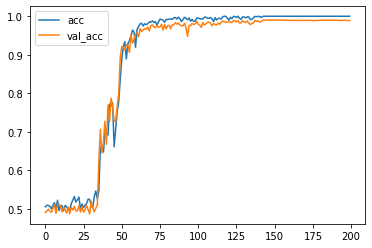

In [119]:
# Plot the accuracy
plt.plot(r.history['accuracy'], label='acc')
plt.plot(r.history['val_accuracy'], label='val_acc')
plt.legend()

 - 30 steps

In [122]:
# Make the problem harder by making T larger
T = 30
D = 1
X = []
Y = []

for t in range(5000):
    x = np.random.randn(T)
    X.append(x)
    y = get_label(x, 0, 1, 2) # long distance
    Y.append(y)

X = np.array(X)
Y = np.array(Y)
N = len(X)

In [123]:
# Now test our LSTM
inputs = np.expand_dims(X, -1)
tf.random.set_seed(123)
# make the RNN
i = Input(shape=(T, D))

# method 1
x = LSTM(50)(i)

x = Dense(1, activation='sigmoid')(x)
model = Model(i, x)
model.compile(
  loss='binary_crossentropy',
  optimizer=Adam(lr=0.01),
  metrics=['accuracy'],
)

# train the RNN
r = model.fit(
  inputs, Y,
  epochs=200,
  validation_split=0.5,
)

Epoch 1/200
79/79 [==============================] - 2s 21ms/step - loss: 0.6947 - accuracy: 0.5024 - val_loss: 0.6937 - val_accuracy: 0.4900
Epoch 2/200
79/79 [==============================] - 1s 16ms/step - loss: 0.6939 - accuracy: 0.4908 - val_loss: 0.6938 - val_accuracy: 0.4896
Epoch 3/200
79/79 [==============================] - 1s 16ms/step - loss: 0.6931 - accuracy: 0.5072 - val_loss: 0.6929 - val_accuracy: 0.5032
Epoch 4/200
79/79 [==============================] - 1s 15ms/step - loss: 0.6932 - accuracy: 0.5036 - val_loss: 0.6949 - val_accuracy: 0.4904
Epoch 5/200
79/79 [==============================] - 1s 15ms/step - loss: 0.6934 - accuracy: 0.4996 - val_loss: 0.6946 - val_accuracy: 0.4916
Epoch 6/200
79/79 [==============================] - 1s 14ms/step - loss: 0.6932 - accuracy: 0.5044 - val_loss: 0.6935 - val_accuracy: 0.4928
Epoch 7/200
79/79 [==============================] - 1s 14ms/step - loss: 0.6928 - accuracy: 0.5152 - val_loss: 0.6932 - val_accuracy: 0.5096
Epoch 

79/79 [==============================] - 1s 15ms/step - loss: 7.3003e-05 - accuracy: 1.0000 - val_loss: 0.2026 - val_accuracy: 0.9732
Epoch 115/200
79/79 [==============================] - 1s 15ms/step - loss: 6.8154e-05 - accuracy: 1.0000 - val_loss: 0.2036 - val_accuracy: 0.9724
Epoch 116/200
79/79 [==============================] - 1s 15ms/step - loss: 6.2158e-05 - accuracy: 1.0000 - val_loss: 0.2033 - val_accuracy: 0.9736
Epoch 117/200
79/79 [==============================] - 1s 15ms/step - loss: 6.0244e-05 - accuracy: 1.0000 - val_loss: 0.2035 - val_accuracy: 0.9740
Epoch 118/200
79/79 [==============================] - 1s 15ms/step - loss: 5.6006e-05 - accuracy: 1.0000 - val_loss: 0.2063 - val_accuracy: 0.9732
Epoch 119/200
79/79 [==============================] - 1s 15ms/step - loss: 5.1785e-05 - accuracy: 1.0000 - val_loss: 0.2089 - val_accuracy: 0.9728
Epoch 120/200
79/79 [==============================] - 1s 14ms/step - loss: 4.7947e-05 - accuracy: 1.0000 - val_loss: 0.2096 -

79/79 [==============================] - 1s 17ms/step - loss: 7.5227e-05 - accuracy: 1.0000 - val_loss: 0.1034 - val_accuracy: 0.9828
Epoch 171/200
79/79 [==============================] - 1s 17ms/step - loss: 0.0435 - accuracy: 0.9868 - val_loss: 0.0713 - val_accuracy: 0.9776
Epoch 172/200
79/79 [==============================] - 1s 16ms/step - loss: 0.0668 - accuracy: 0.9832 - val_loss: 0.0565 - val_accuracy: 0.9836
Epoch 173/200
79/79 [==============================] - 1s 17ms/step - loss: 0.0572 - accuracy: 0.9848 - val_loss: 0.0637 - val_accuracy: 0.9784
Epoch 174/200
79/79 [==============================] - 1s 17ms/step - loss: 0.0505 - accuracy: 0.9820 - val_loss: 0.0627 - val_accuracy: 0.9804
Epoch 175/200
79/79 [==============================] - 1s 17ms/step - loss: 0.0267 - accuracy: 0.9908 - val_loss: 0.0393 - val_accuracy: 0.9856
Epoch 176/200
79/79 [==============================] - 1s 16ms/step - loss: 0.0256 - accuracy: 0.9920 - val_loss: 0.0467 - val_accuracy: 0.9840
Ep

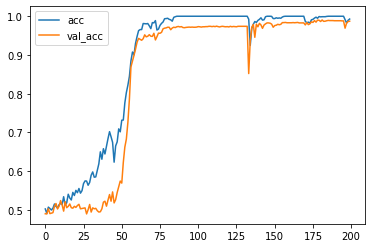

In [124]:
# Plot the accuracy
plt.plot(r.history['accuracy'], label='acc')
plt.plot(r.history['val_accuracy'], label='val_acc')
plt.legend()

 - 60 steps

In [125]:
# Make the problem harder by making T larger
T = 60
D = 1
X = []
Y = []

for t in range(5000):
    x = np.random.randn(T)
    X.append(x)
    y = get_label(x, 0, 1, 2) # long distance
    Y.append(y)

X = np.array(X)
Y = np.array(Y)
N = len(X)

In [126]:
# Now test our LSTM
inputs = np.expand_dims(X, -1)
tf.random.set_seed(123)
# make the RNN
i = Input(shape=(T, D))

# method 1
x = LSTM(50)(i)

x = Dense(1, activation='sigmoid')(x)
model = Model(i, x)
model.compile(
  loss='binary_crossentropy',
  optimizer=Adam(lr=0.01),
  metrics=['accuracy'],
)

# train the RNN
r = model.fit(
  inputs, Y,
  epochs=200,
  validation_split=0.5,
)

Epoch 1/200
79/79 [==============================] - 3s 35ms/step - loss: 0.6974 - accuracy: 0.5040 - val_loss: 0.6933 - val_accuracy: 0.4908
Epoch 2/200
79/79 [==============================] - 2s 26ms/step - loss: 0.6937 - accuracy: 0.4980 - val_loss: 0.6932 - val_accuracy: 0.4996
Epoch 3/200
79/79 [==============================] - 2s 26ms/step - loss: 0.6936 - accuracy: 0.5084 - val_loss: 0.6931 - val_accuracy: 0.5000
Epoch 4/200
79/79 [==============================] - 2s 26ms/step - loss: 0.6931 - accuracy: 0.5108 - val_loss: 0.6932 - val_accuracy: 0.5032
Epoch 5/200
79/79 [==============================] - 2s 26ms/step - loss: 0.6935 - accuracy: 0.5044 - val_loss: 0.6938 - val_accuracy: 0.4968
Epoch 6/200
79/79 [==============================] - 2s 25ms/step - loss: 0.6939 - accuracy: 0.5012 - val_loss: 0.6936 - val_accuracy: 0.5048
Epoch 7/200
79/79 [==============================] - 2s 26ms/step - loss: 0.6934 - accuracy: 0.5076 - val_loss: 0.6931 - val_accuracy: 0.5100
Epoch 

79/79 [==============================] - 2s 28ms/step - loss: 0.6840 - accuracy: 0.5456 - val_loss: 0.6852 - val_accuracy: 0.5412
Epoch 116/200
79/79 [==============================] - 2s 27ms/step - loss: 0.6882 - accuracy: 0.5496 - val_loss: 0.6860 - val_accuracy: 0.5388
Epoch 117/200
79/79 [==============================] - 2s 27ms/step - loss: 0.6944 - accuracy: 0.5220 - val_loss: 0.6925 - val_accuracy: 0.5172
Epoch 118/200
79/79 [==============================] - 2s 28ms/step - loss: 0.6900 - accuracy: 0.5316 - val_loss: 0.6908 - val_accuracy: 0.5448
Epoch 119/200
79/79 [==============================] - 2s 27ms/step - loss: 0.6906 - accuracy: 0.5324 - val_loss: 0.7108 - val_accuracy: 0.5148
Epoch 120/200
79/79 [==============================] - 2s 27ms/step - loss: 0.6886 - accuracy: 0.5332 - val_loss: 0.6901 - val_accuracy: 0.5396
Epoch 121/200
79/79 [==============================] - 2s 29ms/step - loss: 0.6905 - accuracy: 0.5224 - val_loss: 0.6930 - val_accuracy: 0.5148
Epoch 

Epoch 172/200
79/79 [==============================] - 3s 32ms/step - loss: 0.5215 - accuracy: 0.6788 - val_loss: 0.4964 - val_accuracy: 0.7160
Epoch 173/200
79/79 [==============================] - 2s 30ms/step - loss: 0.5047 - accuracy: 0.7152 - val_loss: 0.4832 - val_accuracy: 0.7336
Epoch 174/200
79/79 [==============================] - 2s 28ms/step - loss: 0.4617 - accuracy: 0.7520 - val_loss: 0.5237 - val_accuracy: 0.7520
Epoch 175/200
79/79 [==============================] - 2s 28ms/step - loss: 0.4526 - accuracy: 0.7948 - val_loss: 0.4178 - val_accuracy: 0.8196
Epoch 176/200
79/79 [==============================] - 2s 28ms/step - loss: 0.3950 - accuracy: 0.8248 - val_loss: 0.3775 - val_accuracy: 0.8372
Epoch 177/200
79/79 [==============================] - 2s 28ms/step - loss: 0.3676 - accuracy: 0.8368 - val_loss: 0.3403 - val_accuracy: 0.8564
Epoch 178/200
79/79 [==============================] - 2s 28ms/step - loss: 0.3328 - accuracy: 0.8504 - val_loss: 0.3389 - val_accuracy:

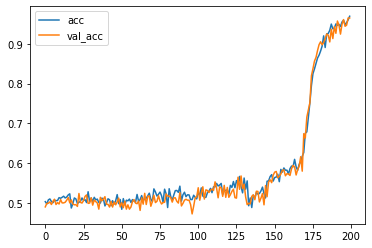

In [127]:
# Plot the accuracy
plt.plot(r.history['accuracy'], label='acc')
plt.plot(r.history['val_accuracy'], label='val_acc')
plt.legend()

 - As we increase the number of time-steps convergence speed decrease
 
 - 1 Last one with 200 steps, to see what happens when we push the LSTM

In [128]:
# Make the problem harder by making T larger
T = 200
D = 1
X = []
Y = []

for t in range(5000):
    x = np.random.randn(T)
    X.append(x)
    y = get_label(x, 0, 1, 2) # long distance
    Y.append(y)

X = np.array(X)
Y = np.array(Y)
N = len(X)

In [129]:
# Now test our LSTM
inputs = np.expand_dims(X, -1)
tf.random.set_seed(123)
# make the RNN
i = Input(shape=(T, D))

# method 1
x = LSTM(50)(i)

x = Dense(1, activation='sigmoid')(x)
model = Model(i, x)
model.compile(
  loss='binary_crossentropy',
  optimizer=Adam(lr=0.01),
  metrics=['accuracy'],
)

# train the RNN
r = model.fit(
  inputs, Y,
  epochs=200,
  validation_split=0.5,
)

Epoch 1/200
79/79 [==============================] - 8s 104ms/step - loss: 0.6954 - accuracy: 0.4892 - val_loss: 0.6932 - val_accuracy: 0.5124
Epoch 2/200
79/79 [==============================] - 6s 72ms/step - loss: 0.6941 - accuracy: 0.4924 - val_loss: 0.6931 - val_accuracy: 0.5080
Epoch 3/200
79/79 [==============================] - 6s 72ms/step - loss: 0.6934 - accuracy: 0.5104 - val_loss: 0.6935 - val_accuracy: 0.5124
Epoch 4/200
79/79 [==============================] - 6s 72ms/step - loss: 0.6933 - accuracy: 0.5028 - val_loss: 0.6932 - val_accuracy: 0.5160
Epoch 5/200
79/79 [==============================] - 6s 71ms/step - loss: 0.6935 - accuracy: 0.5008 - val_loss: 0.6934 - val_accuracy: 0.4780
Epoch 6/200
79/79 [==============================] - 6s 71ms/step - loss: 0.6935 - accuracy: 0.4980 - val_loss: 0.6931 - val_accuracy: 0.5120
Epoch 7/200
79/79 [==============================] - 6s 73ms/step - loss: 0.6934 - accuracy: 0.4976 - val_loss: 0.6935 - val_accuracy: 0.4920
Epoch

79/79 [==============================] - 7s 93ms/step - loss: 0.6041 - accuracy: 0.6484 - val_loss: 0.8013 - val_accuracy: 0.4892
Epoch 116/200
79/79 [==============================] - 7s 91ms/step - loss: 0.6035 - accuracy: 0.6472 - val_loss: 0.7801 - val_accuracy: 0.4908
Epoch 117/200
79/79 [==============================] - 7s 91ms/step - loss: 0.6273 - accuracy: 0.6280 - val_loss: 0.7789 - val_accuracy: 0.5052
Epoch 118/200
79/79 [==============================] - 7s 90ms/step - loss: 0.7116 - accuracy: 0.5860 - val_loss: 0.8382 - val_accuracy: 0.5072
Epoch 119/200
79/79 [==============================] - 7s 91ms/step - loss: 0.7354 - accuracy: 0.5472 - val_loss: 0.7586 - val_accuracy: 0.5036
Epoch 120/200
79/79 [==============================] - 7s 91ms/step - loss: 0.6819 - accuracy: 0.5544 - val_loss: 0.7394 - val_accuracy: 0.5060
Epoch 121/200
79/79 [==============================] - 7s 90ms/step - loss: 0.6713 - accuracy: 0.5680 - val_loss: 0.7417 - val_accuracy: 0.5048
Epoch 

Epoch 172/200
79/79 [==============================] - 7s 90ms/step - loss: 0.6916 - accuracy: 0.5280 - val_loss: 0.6973 - val_accuracy: 0.5032
Epoch 173/200
79/79 [==============================] - 7s 90ms/step - loss: 0.6920 - accuracy: 0.5368 - val_loss: 0.7000 - val_accuracy: 0.5064
Epoch 174/200
79/79 [==============================] - 7s 90ms/step - loss: 0.6920 - accuracy: 0.5212 - val_loss: 0.7001 - val_accuracy: 0.5084
Epoch 175/200
79/79 [==============================] - 7s 90ms/step - loss: 0.6918 - accuracy: 0.5304 - val_loss: 0.6980 - val_accuracy: 0.4968
Epoch 176/200
79/79 [==============================] - 7s 90ms/step - loss: 0.6907 - accuracy: 0.5328 - val_loss: 0.6978 - val_accuracy: 0.4948
Epoch 177/200
79/79 [==============================] - 7s 88ms/step - loss: 0.6902 - accuracy: 0.5344 - val_loss: 0.6985 - val_accuracy: 0.4888
Epoch 178/200
79/79 [==============================] - 7s 90ms/step - loss: 0.6903 - accuracy: 0.5292 - val_loss: 0.6970 - val_accuracy:

 - LSTM fails to learn 200 steps, even LSTM has a limit

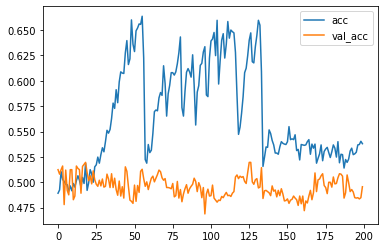

In [130]:
# Plot the accuracy
plt.plot(r.history['accuracy'], label='acc')
plt.plot(r.history['val_accuracy'], label='val_acc')
plt.legend()

 - Trying with global max pooling to see if we can information like that.

In [138]:
# Now test our LSTM
inputs = np.expand_dims(X, -1)
tf.random.set_seed(123)
# make the RNN
i = Input(shape=(T, D))

# method 1
x = LSTM(50, return_sequences=True)(i)
x = GlobalMaxPooling1D()(x)
x = Dense(1, activation='sigmoid')(x)
model = Model(i, x)
model.compile(
  loss='binary_crossentropy',
  optimizer=Adam(lr=0.01),
  metrics=['accuracy'],
)

model.summary()

Model: "model_44"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_46 (InputLayer)        [(None, 200, 1)]          0         
_________________________________________________________________
lstm_30 (LSTM)               (None, 200, 50)           10400     
_________________________________________________________________
global_max_pooling1d_2 (Glob (None, 50)                0         
_________________________________________________________________
dense_44 (Dense)             (None, 1)                 51        
Total params: 10,451
Trainable params: 10,451
Non-trainable params: 0
_________________________________________________________________


In [134]:
r = model.fit(
  inputs, Y,
  epochs=200,
  validation_split=0.5,
)

Epoch 1/200
79/79 [==============================] - 8s 99ms/step - loss: 0.6969 - accuracy: 0.4956 - val_loss: 0.6943 - val_accuracy: 0.5124
Epoch 2/200
79/79 [==============================] - 6s 73ms/step - loss: 0.6947 - accuracy: 0.5080 - val_loss: 0.6943 - val_accuracy: 0.4876
Epoch 3/200
79/79 [==============================] - 6s 73ms/step - loss: 0.6935 - accuracy: 0.5116 - val_loss: 0.6934 - val_accuracy: 0.5124
Epoch 4/200
79/79 [==============================] - 6s 72ms/step - loss: 0.6938 - accuracy: 0.4868 - val_loss: 0.6930 - val_accuracy: 0.5124
Epoch 5/200
79/79 [==============================] - 6s 72ms/step - loss: 0.6935 - accuracy: 0.5020 - val_loss: 0.6931 - val_accuracy: 0.4884
Epoch 6/200
79/79 [==============================] - 6s 73ms/step - loss: 0.6931 - accuracy: 0.4940 - val_loss: 0.6928 - val_accuracy: 0.5124
Epoch 7/200
79/79 [==============================] - 6s 79ms/step - loss: 0.6929 - accuracy: 0.5128 - val_loss: 0.6921 - val_accuracy: 0.5396
Epoch 

KeyboardInterrupt: 

In [139]:
r = model.fit(
  inputs, Y,
  epochs=30,
  validation_split=0.5,
)

Epoch 1/30
79/79 [==============================] - 8s 98ms/step - loss: 0.6969 - accuracy: 0.4956 - val_loss: 0.6943 - val_accuracy: 0.5124
Epoch 2/30
79/79 [==============================] - 6s 72ms/step - loss: 0.6947 - accuracy: 0.5080 - val_loss: 0.6943 - val_accuracy: 0.4876
Epoch 3/30
79/79 [==============================] - 6s 72ms/step - loss: 0.6935 - accuracy: 0.5116 - val_loss: 0.6934 - val_accuracy: 0.5124
Epoch 4/30
79/79 [==============================] - 6s 72ms/step - loss: 0.6938 - accuracy: 0.4868 - val_loss: 0.6930 - val_accuracy: 0.5124
Epoch 5/30
79/79 [==============================] - 6s 71ms/step - loss: 0.6935 - accuracy: 0.5020 - val_loss: 0.6931 - val_accuracy: 0.4884
Epoch 6/30
79/79 [==============================] - 6s 72ms/step - loss: 0.6931 - accuracy: 0.4940 - val_loss: 0.6928 - val_accuracy: 0.5124
Epoch 7/30
79/79 [==============================] - 6s 72ms/step - loss: 0.6929 - accuracy: 0.5128 - val_loss: 0.6921 - val_accuracy: 0.5396
Epoch 8/30
79

 - GlobalMaxPooling help us to model long processes, this is a quite useful property for NLP

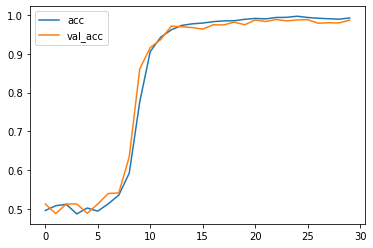

In [140]:
# Plot the accuracy
plt.plot(r.history['accuracy'], label='acc')
plt.plot(r.history['val_accuracy'], label='val_acc')
plt.legend()